## Tutorial: Prediction with RDL-SIM 
In this notebook, we do full image prediction on mid.SNR Microtubules data with pre-trained model. 

In [ ]:

import datetime
from csbdeep.io import load_training_data
from csbdeep.utils import axes_dict, plot_some, plot_history
import matplotlib.pyplot as plt
# from models_varun_new import Denoiser, Train_RDL_Denoising
from rdl_denoising.models import Denoiser, Train_RDL_Denoising
from rdl_denoising.loss_functions import mse_ssim, mse_ssim_psnr 
import tensorflow as tf
import os
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.callbacks import TensorBoard
from wandb.integration.keras import WandbMetricsLogger, WandbEvalCallback
import numpy as np
from csbdeep.utils import normalize
# from tensorflow.image import psnr, ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import normalized_root_mse as sklearn_nrmse
import tifffile
######  login WANDB #########
import wandb
from rdl_denoising.model_DFCAN import DFCAN
import psutil
import mrcfile

import os
# Tell CUDA not to see any GPUs
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

# sanity check: should report zero GPUs
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [14]:



root_dir = '../dataset/microtubules'

den_model_dir = '../trained_models/microtubules/MT-DN-mid-SNR' 
sr_model_dir = "../trained_models/microtubules/DFCAN_complete"# now trained for 02 as well

otf_path = '../dataset/TIRF488_cam1_0_z30_OTF2d.mrc' # the otf from the RDL-Sim package

log_dir = "logs/fitDN/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

output_dir = Path.cwd() / 'DN_preidctions'
output_dir.mkdir(parents=True, exist_ok=True)


print(f'sr model : {sr_model_dir}') # provide the path to the SR model
print(f'dn model : {den_model_dir}') # provide the path to

sr model : ../trained_models/microtubules/DFCAN_complete
dn model : ../trained_models/microtubules/MT-DN-mid-SNR


### Load the test Image files. 
 Note: we load input, target and high quality SIM reconstruction image from the dataset for visual comparision

In [15]:

cell_number = '001' # mt cells 25, 43, 47
noise_level = '04'

mrc_file =  f'../dataset/microtubules/test/Cell_{cell_number}/RawSIMData_level_{noise_level}.mrc' #'14,  21, 30, 37'
 
gt_image =  f'../dataset/microtubules/test/Cell_{cell_number}/RawSIMData_gt.mrc'

gt_Sr_image = f'../dataset/microtubules/test/Cell_{cell_number}/SIM_gt.mrc'
# first lets read teh file: 
with mrcfile.open(mrc_file, mode='r', permissive = True) as mrc:
    full_image = mrc.data

with mrcfile.open(gt_image, mode='r', permissive = True) as mrc:
    gt_full_image = mrc.data

with mrcfile.open(gt_Sr_image, mode='r', permissive = True) as mrc:
    gt_Sr_image = mrc.data

# normalize the image based on percentile normalization
full_image = normalize(full_image)
gt_full_image = normalize(gt_full_image)


# transpose the image to have the channel last
full_image = np.transpose(full_image, (1, 2, 0))
gt_full_image = np.transpose(gt_full_image, (1, 2, 0))

print(f'full image shape: {full_image.shape}')
print(f'gt image shape: {gt_full_image.shape}')
print(f'gt sr image shape: {gt_Sr_image.shape}')

full image shape: (502, 502, 9)
gt image shape: (502, 502, 9)
gt sr image shape: (1004, 1004)


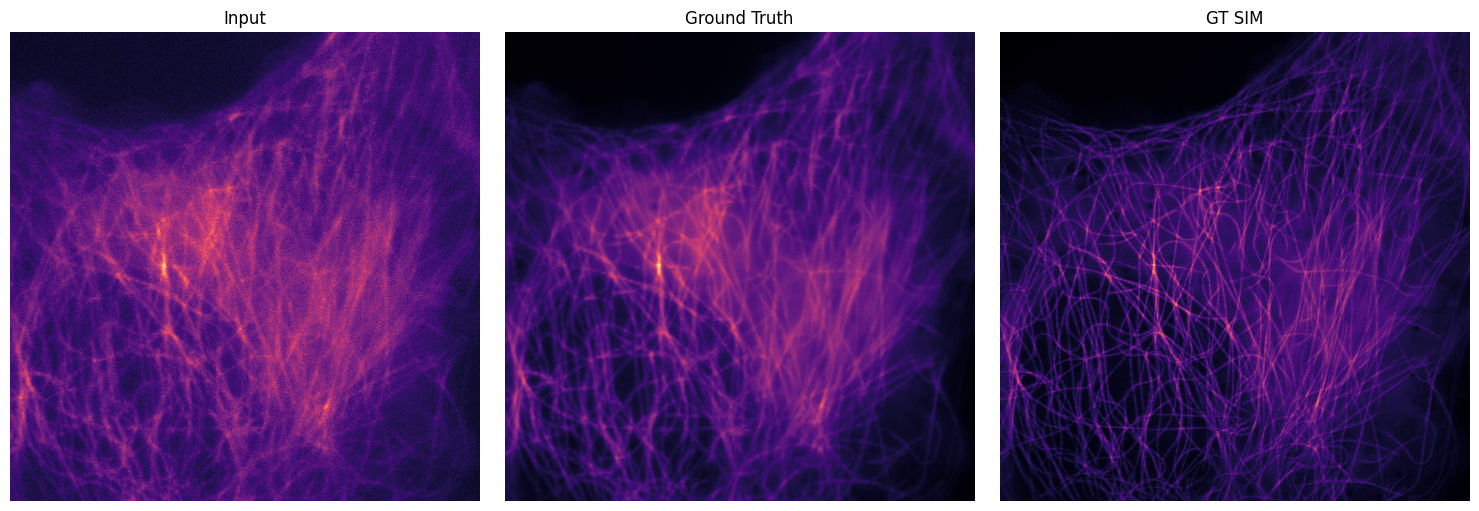

In [16]:
def visualize_images(input_img, gt_img, gt_sim):
    """
    Visualize the images side by side.
    
    For any image that has a 3rd dimension (channels), displays only the first channel.
    
    Parameters:
      input_img: numpy.ndarray, the input image (could be 2D or 3D)
      gt_img: numpy.ndarray, the ground truth image (2D or 3D)
      gt_sim: numpy.ndarray, the GT SIM image (assumed 2D)
    """
    # Choose the first channel if image has multiple channels
    input_disp = input_img if input_img.ndim == 2 else input_img[..., 0]
    gt_disp = gt_img if gt_img.ndim == 2 else gt_img[..., 0]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    im0 = axes[0].imshow(input_disp, cmap='magma')
    axes[0].set_title("Input")
    axes[0].axis('off')
    
    im1 = axes[1].imshow(gt_disp, cmap='magma')
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')
    
    im2 = axes[2].imshow(gt_sim, cmap='magma')
    axes[2].set_title("GT SIM")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_images(full_image, gt_full_image, gt_Sr_image)


### Setup the paramerts that were used in the training
- Note, image hight and width must be the size of the image being used for prediction

In [17]:


init_lr = 1e-4
lr_decay_factor =.67	# Learning rate decay factor	

batch_size = 4
epochs = 5
beta_1=0.9
beta_2=0.999
wavelength = 0.488
# wavelength = 488 
excNA = 1.35
# excNA = 1.3 # uni data
# dx = 80.8e-3 # change here
dx = 62.6e-3
dy = dx
# dx = 80.8e-3 # uni data
# dy = 80.8e-3 # uni dataa


dxy = dx 
scale_gt = 2.0
setupNUM = 0
space = wavelength/excNA/2 # here is teh change = /2
k0mod = 1 / space
napodize = 10
nphases = 3
ndirs = 3
sigma_x = 0.5
sigma_y = 0.5
recalcarrays = 2
ifshowmodamp = 0
otf_path = '../dataset/TIRF488_cam1_0_z30_OTF2d.mrc' # the otf from the RDL-Sim package
norders = int((nphases + 1) / 2)
if setupNUM == 0:
    k0angle_c = [1.48, 2.5272, 3.5744]
    k0angle_g = [0.0908, -0.9564, -2.0036]  
if setupNUM == 1:
    k0angle_c = [-1.66, -0.6128, 0.4344]
    k0angle_g = [3.2269, 2.1797, 1.1325]      
if setupNUM == 2:
    k0angle_c = [1.5708, 2.618, 3.6652]
    k0angle_g = [0, -1.0472, -2.0944] 

height, width, channels = full_image.shape
print(f'\n\n ,  height, width, channels : { height, width, channels} \n\n')
print('This are the startting parameters for the training')
print(f'init_lr : {init_lr} \nepochs : {epochs} \nbatch_size : {batch_size} \nbeta_1 : {beta_1} \nbeta_2 : {beta_2} \n')

########### define parameter dictionary ################
parameters = {
    'Ny': height,
    'Nx': width,
    'lr_decay_factor': lr_decay_factor,
    'wavelength':wavelength,
    'excNA':excNA,
    'ndirs':ndirs,
    'nphases':nphases,
    'init_lr': init_lr,
    'ifshowmodamp':ifshowmodamp,
    'batch_size': batch_size,
    'epochs': epochs,
    'beta_1':beta_1,
    'beta_2':beta_2,
    'scale_gt': scale_gt,
    'setupNUM': setupNUM,
    'k0angle_c':k0angle_c,
    'k0angle_g':k0angle_g,
    'recalcarrays':recalcarrays,
    'dxy':dxy,
    'space':space,
    'k0mod':k0mod,
    'norders':norders,
    'napodize':napodize,
    'scale': scale_gt,
    'sigma_x': sigma_x,
    'sigma_y': sigma_y,
    'log_dir': log_dir,
    'den_model_dir': den_model_dir,
    'sr_model_dir': sr_model_dir,
    'otf_path' : otf_path,
    'results_path': output_dir        
}






 ,  height, width, channels : (502, 502, 9) 


This are the startting parameters for the training
init_lr : 0.0001 
epochs : 5 
batch_size : 4 
beta_1 : 0.9 
beta_2 : 0.999 



### Load the pre-trained models

In [18]:

if len(os.listdir(sr_model_dir)) > 0:

        with tf.keras.utils.custom_object_scope({'mse_ssim': mse_ssim}):
            if len(os.listdir(sr_model_dir)) > 0:
                print(f'Loading model from {sr_model_dir}')
                Trainingmodel_dfcan = DFCAN((height,width,channels), scale=2)
                # Trainingmodel_dfcan = load_model(sr_model_dir)

                optimizer2 = Adam(learning_rate=init_lr, beta_1=beta_1, beta_2=beta_2)
                Trainingmodel_dfcan.load_weights(sr_model_dir)
                Trainingmodel_dfcan.compile(optimizer=optimizer2, loss=mse_ssim)

Loading model from ../trained_models/microtubules/DFCAN_complete


In [ ]:




if len(os.listdir(den_model_dir)) > 0:
        with tf.keras.utils.custom_object_scope({'mse_ssim': mse_ssim}):
            if len(os.listdir(den_model_dir)) > 0:
                print(f'Loading model from {den_model_dir}')
                dn_model = Denoiser((502, 502, 3))
                # dn_model = load_model(den_model_dir)
                optimizer = Adam(learning_rate=init_lr, beta_1=beta_1, beta_2=beta_2)
                dn_model.load_weights(den_model_dir)

                dn_model.compile(loss=mse_ssim, optimizer=optimizer)
else:
    print('Model not found, please train the DN model first')
    assert False, 'DFCAN model has to be trained before training RDL denosier'








Loading model from ../trained_models/microtubules/MT-DN-mid-SNR


In [20]:
rdl_denoising = Train_RDL_Denoising(
                        srmodel=Trainingmodel_dfcan, 
                        denmodel=dn_model,
                        loss_fn=mse_ssim,
                        optimizer=optimizer,
                        parameters = parameters,
                        verbose=False)

Information OTF how its read
(1004, 1004) float64 1.0 -0.0009540839687094419

Information PSF how its read
(1004, 1004) float64 0.010358816948508234 6.953077316541954e-13

Information prol_OTF how its read
(1422,) float64 1.0 -0.0009540839687094419


In [ ]:
# add a batch dimension as 1. 
# Note: for a list of image, you do not need extra batch dimension as the number of images will be the batch here. 
print(full_image.shape)
full_image_predict = np.expand_dims(full_image, axis=0)
print(full_image_predict.shape)

(502, 502, 9)
(1, 502, 502, 9)


## model prediction. 
note: the prediction function returns is a tuple of predictied image and the predictid SR image. 

In [ ]:

_P, image_SR_batch = rdl_denoising.predict(full_image_predict)

print(_P.shape)
print(image_SR_batch.shape)

        #############     #####################     Prediction Started                     ############################                                 #############


In [ ]:
# remove the batch dimension.
# if a list of image, itter over the list to get the predictions.
_P = _P.squeeze()
image_SR_batch = image_SR_batch.squeeze()
print(_P.shape)
print(image_SR_batch.shape)

(502, 502, 9)
(1004, 1004)


## Visualization of the predictions

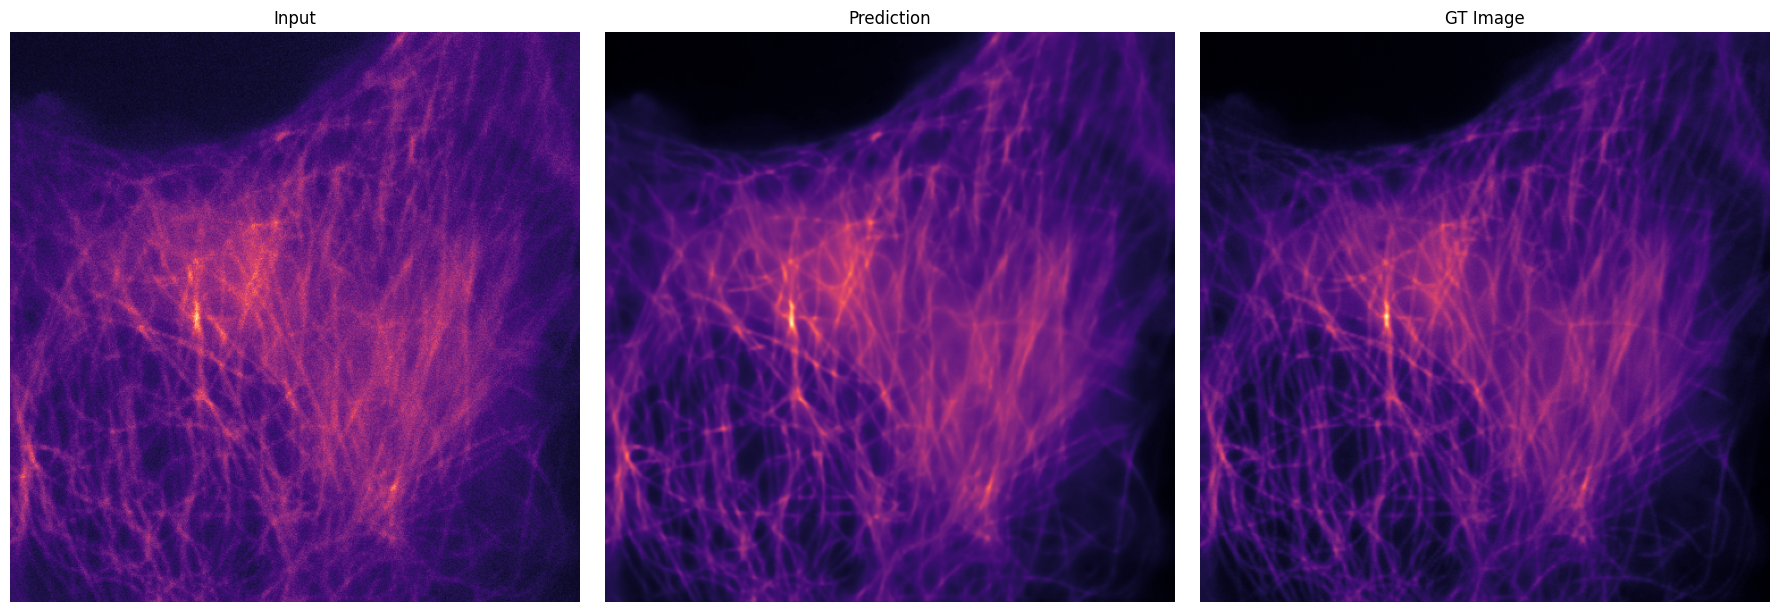

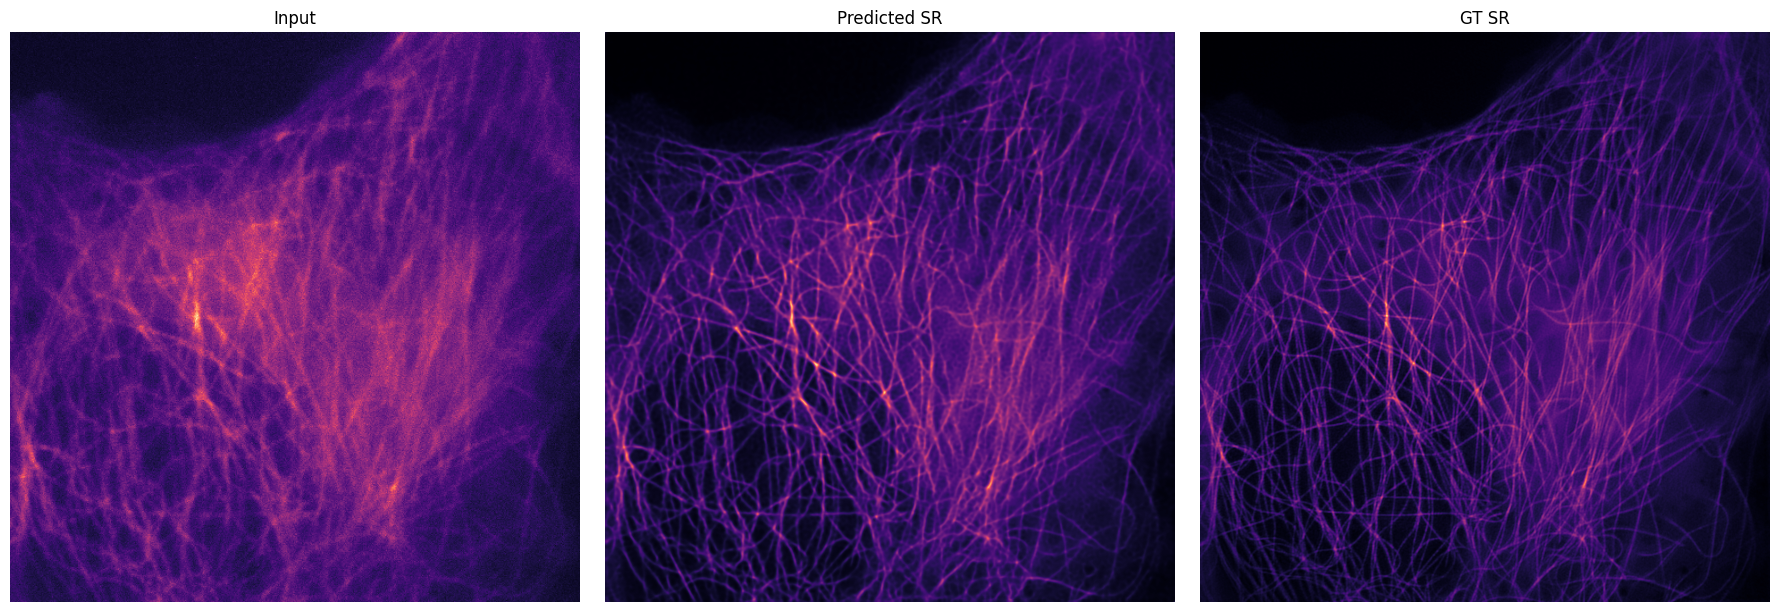

In [ ]:
# For display, we assume the input image is multi-channel and we simply display its first channel.
input_disp = full_image if full_image.ndim == 2 else full_image[..., 0]

# For the prediction image, we select one channel (e.g., the 2nd channel) for visualization.
pred_disp = _P if _P.ndim == 2 else _P[..., 1]

# For the ground truth image, display the first channel as done before.
gt_disp = gt_full_image if gt_full_image.ndim == 2 else gt_full_image[..., 0]

# Plot 1: Input, Prediction, and Ground Truth Image
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(input_disp, cmap='magma')
plt.title("Input")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_disp, cmap='magma')
plt.title("Prediction")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(gt_disp, cmap='magma')
plt.title("GT Image")
plt.axis("off")

plt.tight_layout()
plt.show()

# Plot 2: Input, Predicted SR, and GT SR
# For the SR plot, we assume image_SR_batch is already 2D.
pred_sr = image_SR_batch
# Input for SR can be the same as before.
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(input_disp, cmap='magma')
plt.title("Input")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_sr, cmap='magma')
plt.title("Predicted SR")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(gt_Sr_image, cmap='magma')
plt.title("GT SR")
plt.axis("off")

plt.tight_layout()
plt.show()